## Import

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import maxflow

from scipy.ndimage import convolve, affine_transform
from skimage.feature import peak_local_max
from scipy.signal import find_peaks

import sys
sys.path.insert(1, '..')
from functions import *

PATH = 'data/'

## 5.2 MRF modelling for image segmentation

1. Get hold of the gray-scale image D and one configuration for the segmentation $S$. To begin with, this may be a ground truth segmentation. Notice that a ground truth segmentation (labeling) is not the same as a noise-free image: elements of the segmentation are labels $1, 2, . . .$ while elements of the noise-free image are pixel intensities $µ1, µ2, . . .$

2. For computing $V_1$ you need $D$, $S$ and $\mu$. First, compute an intensity-realization of $S$, that is an image where each occurrence of label $f_i$ is
replaced by $\mu(f_i)$. It is then easy to compute $V_1$ as a sum of squared differences.

3. For computing $V_2$ you need $S$ and $\beta$. Recall that an almost identical problem was solved in week 1.

4. Produce some other configurations $S$, by any means that you find appropriate: thresholding, manually drawing, modifying ground truth... Apply your two functions to all configurations, and display the likelihood, prior and posterior for every configuration.

5. If we consider only the likelihood, which configuration is the most probable? If we consider only the prior energy, which configuration is the most probable? What if we consider the posterior energy?

6. Would you expect that minimizing the posterior energy leads to a good segmentation? If not, try adjusting $\beta$.

In [44]:
image_noise_free = get_gray_image_255(PATH + 'noise_free_circles.png')
image_noisy = get_gray_image_255(PATH + 'noisy_circles.png')

Text(0.5, 1.0, 'Noisy image')

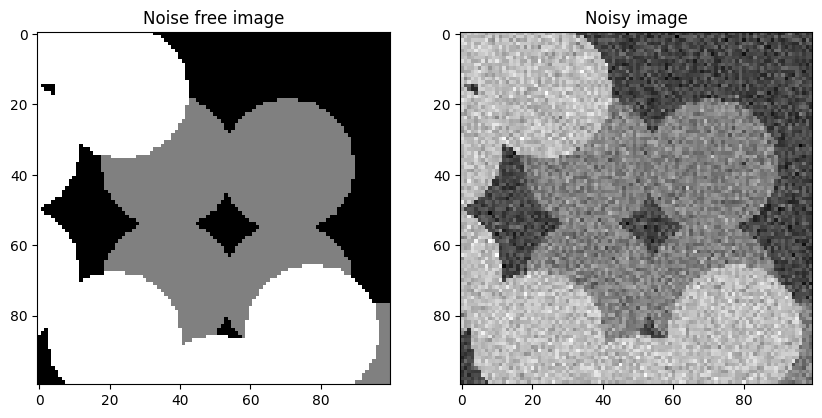

In [45]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(image_noise_free, cmap='gray')
ax[0].set_title('Noise free image')
ax[1].imshow(image_noisy, cmap='gray')
ax[1].set_title('Noisy image')

In [46]:
def plot_image_and_label(image_noise_free, S):
    """
    Plots the noise-free image and the segmented image side by side with a legend.

    Parameters:
        image_noise_free (numpy.ndarray): The noise-free grayscale image.
        S (numpy.ndarray): The segmented image with labels for each pixel.

    Returns:
        None
    """
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(image_noise_free, cmap='gray')
    ax[0].set_title('Noise free image')
    im = ax[1].imshow(S)
    ax[1].set_title('Segmented image')

    # Create a legend for the segmented image with corresponding pixel values
    colors = [im.cmap(im.norm(value)) for value in np.unique(S)]
    labels = [f'Category {i} (Pixel value: {np.unique(image)[i]})' for i in np.unique(S)]
    patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    ax[1].legend(patches, labels, loc='upper right')

def compute_V1(D, S, mu):
    """
    Computes the V1 energy term as the sum of squared differences between 
    the original grayscale image D and the intensity-realized version of S.

    Parameters:
        D (numpy.ndarray): The original grayscale image.
        S (numpy.ndarray): The segmentation (labels for each pixel).
        mu (dict): A dictionary mapping labels to mean intensities.

    Returns:
        float: The computed V1 energy.
    """
    # Create the intensity-realized image of S
    intensity_realized_S = np.vectorize(mu.get)(S) #Maps where the value of S is the key in mu to the value in mu which is the mean intensity of the label
    
    # Compute sum of squared differences
    V1 = np.sum((D - intensity_realized_S) ** 2)
    
    return V1

def compute_V2(S, beta):
    """
    Computes the V2 energy term as the sum of differences between neighboring pixels."
    """
    check_vertically   = beta*np.sum((S[1:, :] != S[:-1,:])) #Check if the pixel below is different from the pixel above
    check_horizontally = beta*np.sum((S[:, 1:] != S[:,:-1]))
    return check_vertically + check_horizontally

{np.uint8(0): np.float64(70.0), np.uint8(1): np.float64(130.0), np.uint8(2): np.float64(190.0)}
The likelihood energy term V1 is: 0.0
The prior term V2 is: 64300
The posterior energy term V1+V2 is: 64300.0
The unique values in the noisy image are: [0 1 2]
The unique values in the noise free image are: [ 70 130 190]



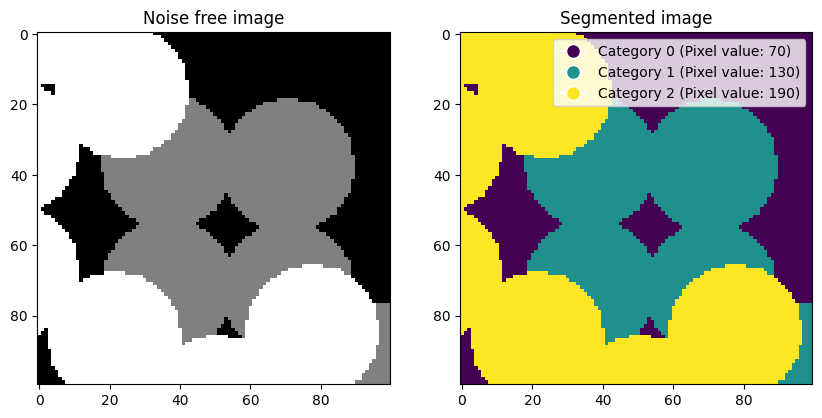

In [47]:
image = image_noise_free

BETA = 100
labels = np.unique(image)
S = np.zeros_like(image)

for i, label in enumerate(labels):
    S[image == label] = i

mu_fi = {i: np.mean(image[S == i]) for i in np.unique(S)}
print(mu_fi)
V1, V2 = compute_V1_and_V2(image, S, mu_fi, BETA, BETA)

plot_image_and_label(image, S)
print(f'The unique values in the noisy image are: {np.unique(S)}')
print(f'The unique values in the noise free image are: {labels}\n')


**Creating new S matrix**

The unique values in the noisy image are: [0 1]
The unique values in the noise free image are: [ 70 130]

The likelihood energy term V1 is: 6479439.879896275
The prior term V2 is: 45800
The posterior energy term V1+V2 is: 6525239.879896275
s
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
{np.uint8(0): np.float64(70.0), np.uint8(1): np.float64(163.95932851098675)}
100


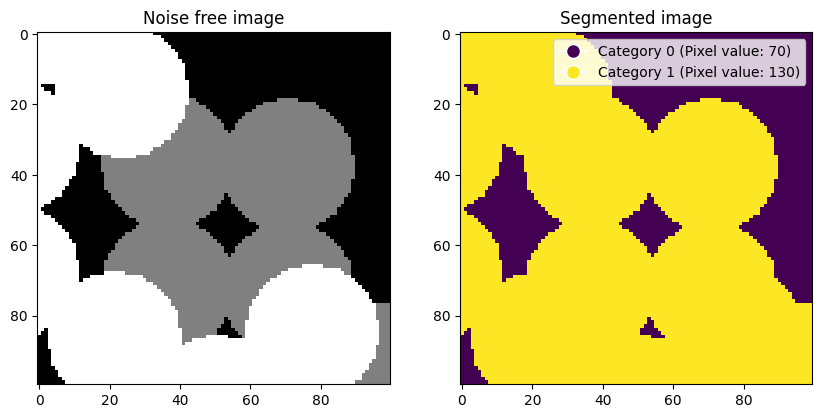

In [48]:
image = image_noise_free

# Get the first to labels
labels = np.unique(image)[:2] 
S = np.zeros_like(image)
S[image > 100] = 1

for i, label in enumerate(labels):
    S[image == label] = i

print(f'The unique values in the noisy image are: {np.unique(S)}')
print(f'The unique values in the noise free image are: {labels}\n')

BETA = 100
mu_fi = {i: np.mean(image[S == i]) for i in np.unique(S)}
V1, V2 = compute_V1_and_V2(image, S, mu_fi, BETA, BETA)

plot_image_and_label(image, S)
print('s')
print(S)
print(mu_fi)
print(BETA)

## 5.3 Graph cuts for optimizing MRF

**Setting up the problem**

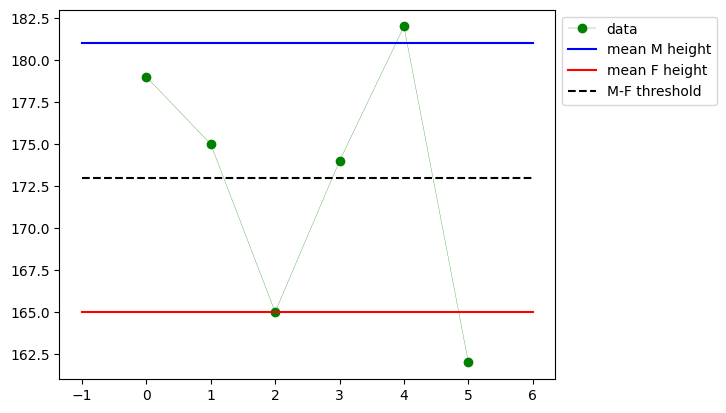

In [49]:
#d = np.array([179, 174, 182, 162, 175, 165]) # heights (data term)
d = np.array([179,  175, 165, 174, 182, 162]) # heights (data term)

mu = [181, 165] # means of two classes, used for computation of likelihood
w_s = (d - mu[0]) ** 2 # source weight
w_t = (d - mu[1]) ** 2 # sink weights

fig, ax = plt.subplots()
ax.plot(d, '-og', lw=0.2, label='data')
ax.plot([-1, len(d)], [mu[0]]*2, 'b', label='mean M height')
ax.plot([-1, len(d)], [mu[1]]*2, 'r', label='mean F height')
ax.plot([-1, len(d)], [0.5*(mu[0] + mu[1])]*2, '--k', label='M-F threshold')
ax.legend(bbox_to_anchor = (1, 1))
plt.show()

Solving the assignment problem using graph-cut

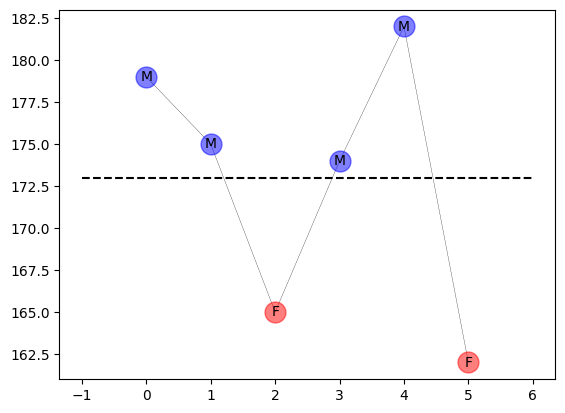

In [50]:
beta = 10  # try changing between 0 and 1000

# Create a graph with integer capacities.
g = maxflow.Graph[int]()

# Add (non-terminal) nodes and retrieve an index for each node.
nodes = g.add_nodes(len(d))

# Create edges between nodes, that is equal to beta
for i in range(len(d)-1):
    g.add_edge(nodes[i], nodes[i+1], beta, beta)

# Set the capacities of the terminal edges.
for i in range(len(d)):
    g.add_tedge(nodes[i], (d[i] - mu[1]) ** 2, (d[i] - mu[0]) ** 2)

# Run the max flow algorithm.
flow = g.maxflow()

# Get the result as integer labels.
labeling = [g.get_segment(n) for n in nodes]

# Visualize
fig, ax = plt.subplots()
ax.plot([-1, len(d)], [0.5*(mu[0] + mu[1])]*2, '--k')
ax.plot(d, '-k', lw=0.2)
for i, di in enumerate(d):
    color = 'b' if labeling[i] == 0 else 'r'
    letter = 'M' if labeling[i] == 0 else 'F'
    ax.plot(i, di, 'o', color=color, alpha=0.5, markersize=15)
    ax.text(i, di, letter, ha='center', va='center')
plt.show()

## 5.4 Binary segmentation using MRF

1. The DTU logo is of type uint8 and should be converted into double precision (float) before any computation. You also want to divide image intensities with 255, as this will simplify the weighting between
the likelihood and the prior term. 

2. For the DTU logo use $µ_1 = 90/255$ and $µ_2 = 170/255$.

3. To pass the weights of terminal and internal edges to graph solver, python users should use the functionality provided by maxflow. See the example Binary image restoration but notice that it uses a different
energy formulation for likelihood term.

4. For the DTU logo, choose parameter β which yields in a good segmentation.

5. The bone image is of type uint16 and after converting it into double precision you may also want to divide image intensities with $216 − 1$.

6. For bone image, you need to determine the mean intensities of the air and bone ($\mu_1$ and $\mu_2$) by inspecting the histogram. Look at maximum likelihood configuration, to confirm that your $\mu_1$ and $\mu_2$ are suitable.
Choose a (small) parameter β and compute the optimal configuration for this $\beta$ using your graph cut solver. Then, adjust $\beta$ to obtain a visually pleasing segmentation with reduced noise in air and bone choose. Observe how changing $\beta$ affects the segmentation. 

7. For your results, you may want to produce a figure showing histogram of the entire image, and on top of that the intensity histograms of the air and bone classes, similar to how it was done in
the modelling exercise.

In [51]:
# def markov_segmentation(image, mu, beta):
#     """
#     Perform Markov Random Field segmentation on the given image.

#     Parameters:
#         image (numpy.ndarray): The input grayscale image to be segmented.
#         mu (list): A list containing the mean intensities for the two classes.
#         beta (float): The parameter controlling the smoothness of the segmentation.

#     Returns:
#         numpy.ndarray: The segmented image with labels for each pixel.
#     """
    
#     d = image.flatten()

#     # Create a graph with integer capacities.
#     g = maxflow.Graph[float]()

#     # Add (non-terminal) nodes and retrieve an index for each node.
#     nodes = g.add_nodes(len(d))

#     # Create edges between nodes, that is equal to beta
#     for i in range(len(d)-1):
#         g.add_edge(nodes[i], nodes[i+1], beta, beta)

#     # Set the capacities of the terminal edges.
#     for i in range(len(d)):
#         g.add_tedge(nodes[i], (d[i] - mu[1]) ** 2, (d[i] - mu[0]) ** 2)

#     # Run the max flow algorithm.
#     flow = g.maxflow()

#     # Get the result as integer labels.
#     labeling = [g.get_segment(n) for n in nodes]
#     return np.array(labeling).reshape(image.shape)

float64


Text(0.5, 1.0, 'Segmented image')

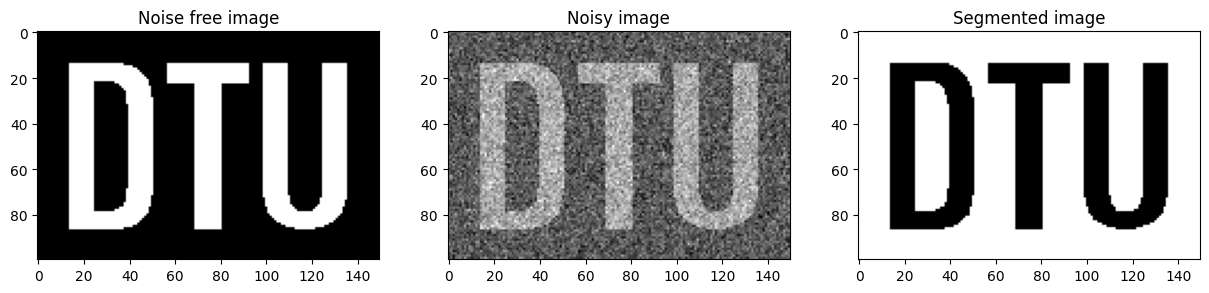

In [58]:
image = get_gray_image_float(PATH + 'DTU.png')
image_noisy = get_gray_image_float(PATH + 'DTU_noisy.png')
print(image.dtype)
mu = [90/255, 170/255]
beta = 0.1
image_segmented = markov_segmentation(image_noisy, mu, beta)    

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Noise free image')
ax[1].imshow(image_noisy, cmap='gray')
ax[1].set_title('Noisy image')
ax[2].imshow(image_segmented, cmap='gray')
ax[2].set_title('Segmented image')

In [ ]:
def compute_and_plot_histogram(image, bins=256, num_max=1, tick_interval=0.05):
    """
    Compute the histogram of the input image, plot it, and return the histogram image and locations of local maxima.

    Parameters:
        image (numpy.ndarray): The input grayscale image.
        bins (int): The number of bins in the histogram.
        num_max (int): The number of local maxima to find.

    Returns:
        tuple: A tuple containing the indices of local maxima in the histogram.
    """
    # Compute the histogram
    hist, bin_edges = np.histogram(image.flatten(), bins=bins, range=(0, 1))
    
    # Find local maxima using scipy's find_peaks function
    local_maxima_indices, _ = find_peaks(hist)
    
    # Sort the local maxima by their heights (histogram values) in descending order
    local_maxima_indices = sorted(local_maxima_indices, key=lambda idx: hist[idx], reverse=True)
    
    # Select the top `num_max` local maxima
    local_maxima_indices = local_maxima_indices[:num_max]
    
    # Plot the histogram
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')
    ax.set_xlabel('Intensity Value')
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of the Image')
    x_ticks = np.arange(0.0, 1.05, tick_interval)  # Generate ticks from 0.0 to 1.0 with the given interval
    ax.set_xticks(x_ticks)  # Set the x-axis ticks
    
    # Mark the local maxima on the histogram
    ax.plot(bin_edges[local_maxima_indices], hist[local_maxima_indices], 'ro', label=f'Local Maxima')
    plt.legend()
    plt.show()

    return bin_edges[local_maxima_indices]

### from solution
def segmentation_histogram(ax, I, S, edges=None):
    '''
    Histogram for data and each segmentation label.
    '''
    if edges is None:
        edges = np.linspace(I.min(), I.max(), 100)
    ax.hist(I.ravel(), bins=edges, color = 'k')
    centers = 0.5 * (edges[:-1] + edges[1:])
    for k in range(S.max() + 1):
        ax.plot(centers, np.histogram(I[S==k].ravel(), edges)[0])

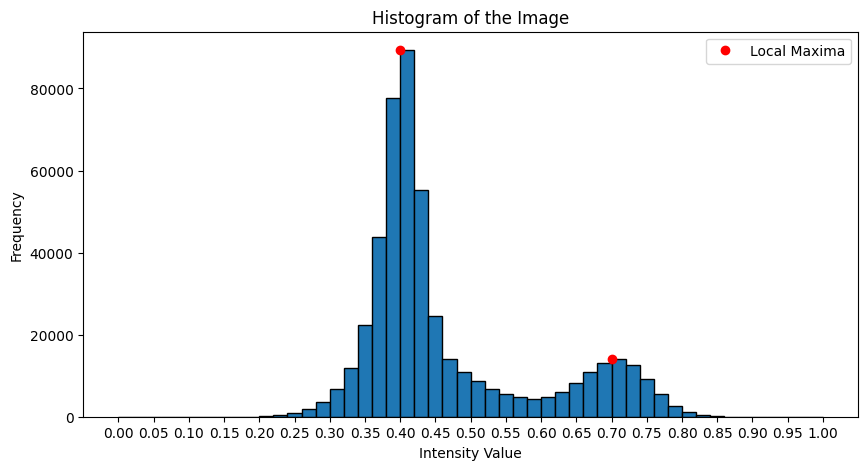

mu: [0.4 0.7]


Text(0.5, 1.0, 'Segmented image')

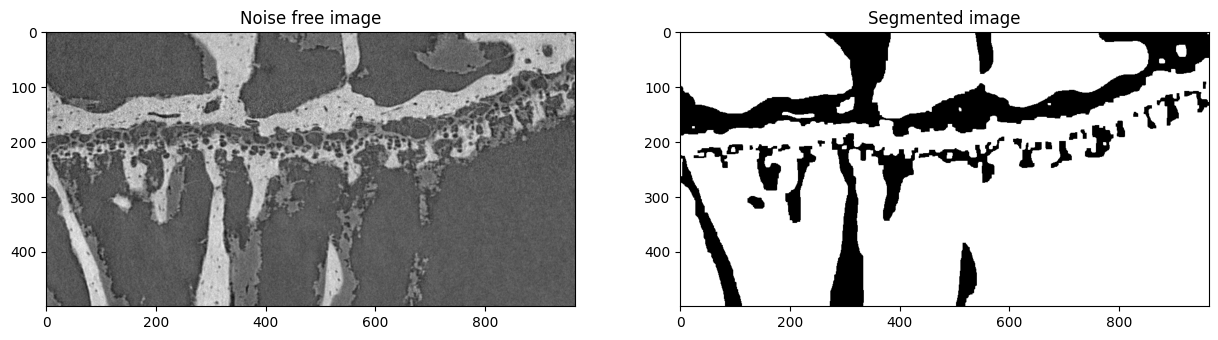

In [68]:
image = get_gray_image_float(PATH + 'V12_10X_x502.png')
mu = compute_and_plot_histogram(image, bins=50, num_max=2)
print(f'mu: {mu}')

beta = 0.1
image_segmented = markov_segmentation(image, mu, beta)    

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Noise free image')
ax[1].imshow(image_segmented, cmap='gray')
ax[1].set_title('Segmented image')

## Quiz

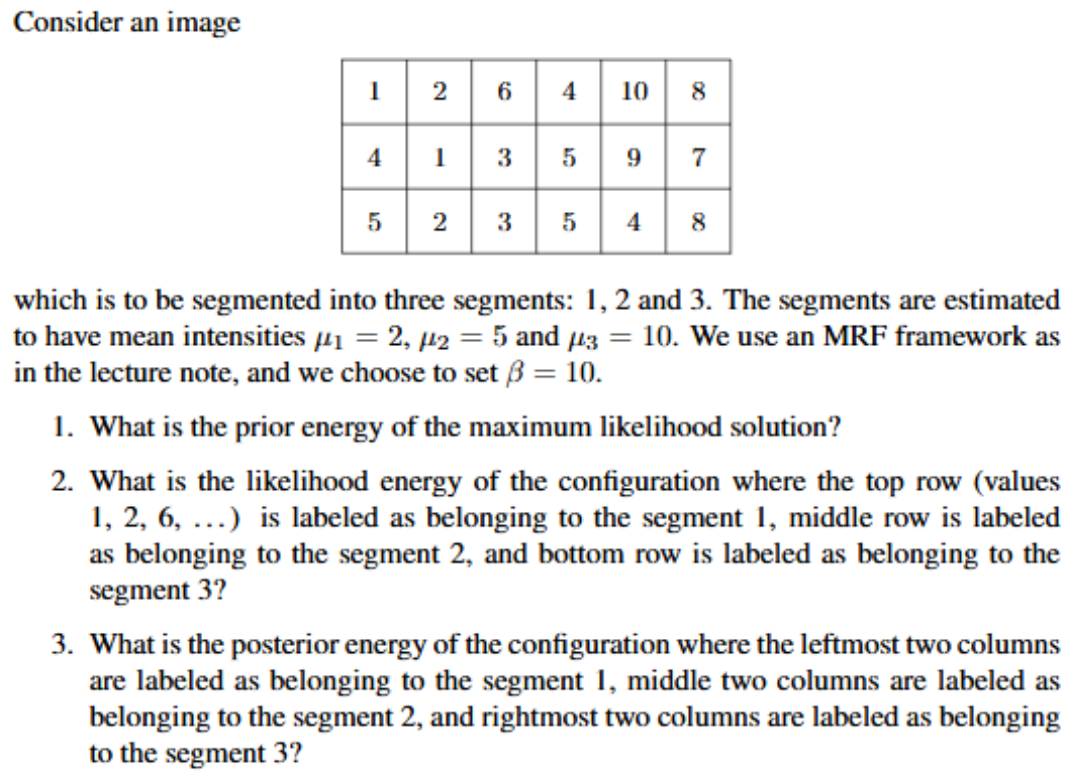

In [55]:
image = np.array([[1, 2, 6, 4, 10, 8], [4, 1, 3, 5, 9, 7] ,[5, 2, 3, 5, 4, 8]])
S_flatten = np.zeros_like(image.flatten())
BETA = 10
mu = np.array([2, 5, 10])

for i, element in enumerate(image.flatten()):
    m = np.argmin(np.abs(element - mu)) + 1     # +1 since we want the first mu to be mu1
    S_flatten[i] = m

S = S_flatten.reshape(image.shape)

print(f'Original image:\n{image}\n')
print(f'S the label image\n{S}\n')

mu_dict = {1: 2.0, 2: 5.0, 3: 10.0}             # need to be floats

V1, V2 = compute_V1_and_V2(image, S, mu_dict, BETA, BETA)

Original image:
[[ 1  2  6  4 10  8]
 [ 4  1  3  5  9  7]
 [ 5  2  3  5  4  8]]

S the label image
[[1 1 2 2 3 3]
 [2 1 1 2 3 2]
 [2 1 1 2 2 3]]

The likelihood energy term V1 is: 21.0
The prior term V2 is: 140
The posterior energy term V1+V2 is: 161.0


In [56]:
image = np.array([[1, 2, 6, 4, 10, 8], [4, 1, 3, 5, 9, 7] ,[5, 2, 3, 5, 4, 8]])
mu_dict = {1: 2.0, 2: 5.0, 3: 10.0}  # need to be floats
BETA = 10

S = np.ones_like(image)
S[1,:] = 2
S[2,:] = 3

print(f'Original image:\n{image}\n')
print(f'S the label image\n{S}\n')
V1, V2 = compute_V1_and_V2(image, S, mu_dict, BETA, BETA)


Original image:
[[ 1  2  6  4 10  8]
 [ 4  1  3  5  9  7]
 [ 5  2  3  5  4  8]]

S the label image
[[1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]]

The likelihood energy term V1 is: 365.0
The prior term V2 is: 120
The posterior energy term V1+V2 is: 485.0


In [57]:
image = np.array([[1, 2, 6, 4, 10, 8], [4, 1, 3, 5, 9, 7] ,[5, 2, 3, 5, 4, 8]])
BETA = 10
mu_dict = {1: 2.0, 2: 5.0, 3: 10.0} # need to be floats

S = np.ones_like(image)
S[:,2:4] = 2
S[:, 4:] = 3

print(f'Original image:\n{image}\n')
print(f'S the label image\n{S}\n')

V1, V2 = compute_V1_and_V2(image, S, mu_dict, BETA, BETA)

Original image:
[[ 1  2  6  4 10  8]
 [ 4  1  3  5  9  7]
 [ 5  2  3  5  4  8]]

S the label image
[[1 1 2 2 3 3]
 [1 1 2 2 3 3]
 [1 1 2 2 3 3]]

The likelihood energy term V1 is: 79.0
The prior term V2 is: 60
The posterior energy term V1+V2 is: 139.0
